# Train ranking model with user representation
 - In the following notebook we will train [DCN model](https://www.tensorflow.org/recommenders/examples/dcn)
 - Model performance will be evaluate via the following metrics:
   - [novelty](https://gab41.lab41.org/recommender-systems-its-not-all-about-the-accuracy-562c7dceeaff):
 $\large\frac{\sum_{u}^{U} \sum_{l}^{L_u} \frac{- log(P_{l})}{|L_u|}}{|U|}$, where $U$ is a set of all users and $L_u$ is a list of recommended arcicles for a user $u$
   - [AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

In [ ]:
# import necessary functionality
import os

try:
    from google.colab import drive

    drive.mount('/content/gdrive')
    BASE_DIR = "/content/gdrive/MyDrive/mlprague2022"
    IN_COLAB = True
except:
    BASE_DIR = ".."
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    IN_COLAB = False

Mounted at /content/gdrive


In [ ]:
!pip install git+https://github.com/seznam/MLPrague-2022.git tensorflow-recommenders==0.5.2

  Cloning https://github.com/seznam/MLPrague-2022.git to /tmp/pip-req-build-x91ylse9
  Running command git clone -q https://github.com/seznam/MLPrague-2022.git /tmp/pip-req-build-x91ylse9
     |████████████████████████████████| 85 kB 2.2 MB/s 
     |████████████████████████████████| 462 kB 33.8 MB/s 
  Created wheel for mlprague22: filename=mlprague22-0.0.0-py3-none-any.whl size=4259 sha256=b34ecf137cd28c9f7b326e0a525b8ea48d5c2c353f1f7863e5b98ae6e042f9fa
  Stored in directory: /tmp/pip-ephem-wheel-cache-6shyaunj/wheels/8e/30/46/f600aaa9e010eb66abaae33828e5ee3596fcdccb523d593440
Successfully built mlprague22


In [ ]:
import gc

from collections import Counter, OrderedDict
from copy import deepcopy

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

import pandas as pd
import numpy as np

import sklearn.metrics as metrics

from itertools import zip_longest

from mlprague22.evaluation import evaluate, sample_users, sample_items

In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 8_192
EPOCHS = 10

OUTPUT_DIR = os.path.join(BASE_DIR, "data/mind_cold_start_datasets_basic/")

COLD_START_BEHAVIORS_TRAIN = os.path.join(OUTPUT_DIR, "behaviors_train.tsv")
COLD_START_BEHAVIORS_TEST = os.path.join(OUTPUT_DIR, "behaviors_test.tsv")
NEWS_CATALOGUE_TRAIN = os.path.join(OUTPUT_DIR, "news_catalogue_train.tsv")
NEWS_CATALOGUE_TEST = os.path.join(OUTPUT_DIR, "news_catalogue_test.tsv")
AUXILIARY_DATA_CATALOGUE_TRAIN = os.path.join(OUTPUT_DIR, "auxiliary_data_catalogue_train.tsv")
AUXILIARY_DATA_CATALOGUE_TEST = os.path.join(OUTPUT_DIR, "auxiliary_data_catalogue_test.tsv")
ALL_CATEGORIES_PATH = os.path.join(OUTPUT_DIR, "categories.tsv")
ALL_SUBCATEGORIES_PATH = os.path.join(OUTPUT_DIR, "subcategories.tsv")
TRAIN_DF_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "train_ex_df.csv")
TEST_DF_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "test_no_item_coldstart_ex_df.csv")
EMBEDDINGS_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "embeddings")
FT_HISTORY_EMBEDDINGS_TRAIN = "ft_histories_train.vec"
FT_HISTORY_EMBEDDINGS_TEST = "ft_histories_test.vec"
EMBEDDINGS_OUTPUT_TRAIN = os.path.join(EMBEDDINGS_OUTPUT_DIR, FT_HISTORY_EMBEDDINGS_TRAIN)
EMBEDDINGS_OUTPUT_TEST = os.path.join(EMBEDDINGS_OUTPUT_DIR, FT_HISTORY_EMBEDDINGS_TEST)
MODEL_DIR = os.path.join(OUTPUT_DIR, "models")

In [ ]:
# load training/evaluation data
CATEGORIES = (
    pd.read_csv(ALL_CATEGORIES_PATH, sep="\t").sort_values("order").category.tolist()
)
# note: subcategories will be used in TASK 1
SUBCATEGORIES = (
    pd.read_csv(ALL_SUBCATEGORIES_PATH, sep="\t").sort_values("order").subcategory.tolist()
)
behaviors_train = pd.read_csv(COLD_START_BEHAVIORS_TRAIN, sep="\t")
behaviors_test = pd.read_csv(COLD_START_BEHAVIORS_TEST, sep="\t")
news_train = pd.read_csv(NEWS_CATALOGUE_TRAIN, sep="\t")
ft_histories_user_vectors_train = np.loadtxt(EMBEDDINGS_OUTPUT_TRAIN, delimiter=",")
ft_histories_user_vectors_test = np.loadtxt(EMBEDDINGS_OUTPUT_TEST, delimiter=",")

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
def set_seed(seed=RANDOM_SEED):
    import random
    import numpy as np
    import tensorflow as tf

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [ ]:
# in order to make this notebook at least partially reproducible set seed of the most common randomness sources
set_seed()

### Load training/eval data
 - Recommender system usualy presents users with slate level recommendation:

 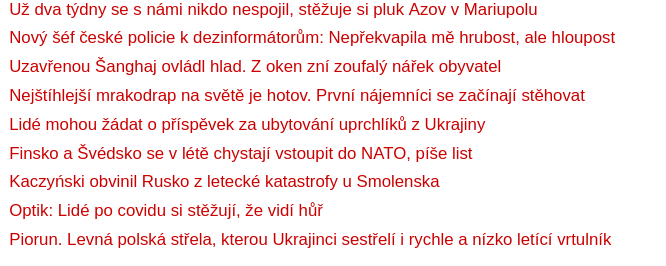


 - But ranking models are trained on single item recommendation and user direct feeedback - all instances on which user clicked are positive instances and those without click are negative
 - Therefore one needs to transform dataset into a format in which each row will match single item recommendation and user feedback
 - We will prepare training and testing dataset and save them in csv format, which can be easily loaded into [tensorflow dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [ ]:
def prepare_dataset(input_path, output_path, emb_vecs):
    behaviors = pd.read_csv(input_path, sep="\t")

    emb_vecs_str = [
        ",".join([str(i) for i in row]) for row in emb_vecs.tolist()
    ]

    e_df = (
        behaviors[
            [
                "userid",
                "slateid",
                "history",
                "impressions",
                "history_all_categories",
                "history_all_subcategories",
            ]
        ]
        .assign(history_all_fasttext_emb=lambda x: emb_vecs_str)
        .assign(
            impression_arr=lambda x: x.impressions.map(
                lambda ii: [i.split("-") for i in ii.split(" ")]
            )
        )
        .explode("impression_arr")
        .assign(impression=lambda x: x.impression_arr.map(lambda xx: xx[0]))
        .assign(click=lambda x: x.impression_arr.map(lambda xx: int(xx[1])))
        .drop("impression_arr", axis=1)
        .assign(history_size=lambda x: x.history.map(lambda xx: len(xx.split())))
    )

    e_df.to_csv(output_path, sep="\t", index=False)

In [ ]:
prepare_dataset(COLD_START_BEHAVIORS_TRAIN, TRAIN_DF_OUTPUT_PATH, ft_histories_user_vectors_train)
train_df = pd.read_csv(TRAIN_DF_OUTPUT_PATH, sep="\t")
display(train_df)

,userid,slateid,history,impressions,history_all_categories,history_all_subcategories,history_all_fasttext_emb,impression,click,history_size
0,U13740,1,N45794 N19347 N31801,N35729-0,tv sports tv news sports lifestyle movies news...,tvnews baseball_mlb tvnews newscrime football_...,"0.02757345512509346,0.05293599143624306,-0.038...",N35729,0,3
1,U91836,2,N31739 N6072 N63045 N43353 N8129 N1569 N17686 ...,N39317-0 N20495-0 N42977-0,news news news finance travel news news news n...,newscrime newsus newscrime markets travelnews ...,"0.023200372233986855,-0.028567129746079445,0.0...",N39317,0,54
2,U91836,2,N31739 N6072 N63045 N43353 N8129 N1569 N17686 ...,N39317-0 N20495-0 N42977-0,news news news finance travel news news news n...,newscrime newsus newscrime markets travelnews ...,"0.023200372233986855,-0.028567129746079445,0.0...",N20495,0,54
3,U91836,2,N31739 N6072 N63045 N43353 N8129 N1569 N17686 ...,N39317-0 N20495-0 N42977-0,news news news finance travel news news news n...,newscrime newsus newscrime markets travelnews ...,"0.023200372233986855,-0.028567129746079445,0.0...",N42977,0,54
4,U73700,3,N7563 N24233,N23877-0 N49712-0 N64174-0 N46821-0 N48017-0 N...,lifestyle lifestyle news sports tv weather spo...,lifestylebuzz lifestylehomeandgarden newsus fo...,"-0.031641364097595215,0.028531450778245926,0.0...",N23877,0,2
...,...,...,...,...,...,...,...,...,...,...
1559405,U44625,156964,N3164 N53854 N44649 N26398 N43983 N16516 N6373...,N3663-0 N31147-0 N4107-0 N27515-0 N20495-0 N18...,lifestyle weather news finance entertainment t...,lifestylehomeandgarden weathertopstories newsw...,"0.010793088935315609,0.009016992524266243,-0.0...",N25561,0,20
1559406,U44625,156964,N3164 N53854 N44649 N26398 N43983 N16516 N6373...,N3663-0 N31147-0 N4107-0 N27515-0 N20495-0 N18...,lifestyle weather news finance entertainment t...,lifestylehomeandgarden weathertopstories newsw...,"0.010793088935315609,0.009016992524266243,-0.0...",N31556,0,20
1559407,U44625,156964,N3164 N53854 N44649 N26398 N43983 N16516 N6373...,N3663-0 N31147-0 N4107-0 N27515-0 N20495-0 N18...,lifestyle weather news finance entertainment t...,lifestylehomeandgarden weathertopstories newsw...,"0.010793088935315609,0.009016992524266243,-0.0...",N23508,0,20
1559408,U44625,156964,N3164 N53854 N44649 N26398 N43983 N16516 N6373...,N3663-0 N31147-0 N4107-0 N27515-0 N20495-0 N18...,lifestyle weather news finance entertainment t...,lifestylehomeandgarden weathertopstories newsw...,"0.010793088935315609,0.009016992524266243,-0.0...",N39317,0,20


In [ ]:
prepare_dataset(COLD_START_BEHAVIORS_TEST, TEST_DF_OUTPUT_PATH, ft_histories_user_vectors_test)
test_df = pd.read_csv(TEST_DF_OUTPUT_PATH, sep="\t")
display(test_df)

,userid,slateid,history,impressions,history_all_categories,history_all_subcategories,history_all_fasttext_emb,impression,click,history_size
0,U80234,1,N46039 N53234 N6616 N63573 N38895,N50775-0,tv news tv news finance autos tv movies entert...,tvnews newsus tv-celebrity newsus finance-comp...,"0.05083860829472542,0.03707544133067131,-0.041...",N50775,0,5
1,U60458,2,N58715 N33438 N54827 N34775,N36779-0,news travel finance news news finance music ne...,newsus travelnews finance-companies newsscienc...,"0.04019559919834137,-0.03583583980798721,0.005...",N36779,0,4
2,U44190,3,N1150 N16233 N53033,N36779-0 N50775-0,sports news tv news lifestyle sports news ente...,football_nfl newscrime tvnews newsus shop-book...,"0.016869867220520973,0.07208146154880524,-0.07...",N36779,0,3
3,U44190,3,N1150 N16233 N53033,N36779-0 N50775-0,sports news tv news lifestyle sports news ente...,football_nfl newscrime tvnews newsus shop-book...,"0.016869867220520973,0.07208146154880524,-0.07...",N50775,0,3
4,U87380,4,N49153 N58518 N7649 N45794 N53033 N29361 N28247,N45057-0,travel news sports sports travel news tv news ...,traveltripideas newsus baseball_mlb football_n...,"-0.027459757402539253,0.055927056819200516,0.0...",N45057,0,7
...,...,...,...,...,...,...,...,...,...,...
402722,U16799,73150,,N45057-0 N16120-0 N7993-0 N5051-0 N50775-0 N33...,tv tv tv music finance movies,tvnews tv-celebrity tv-celebrity musicnews per...,"0.035440344363451004,-0.0001947104901773855,-0...",N33397,0,0
402723,U16799,73150,,N45057-0 N16120-0 N7993-0 N5051-0 N50775-0 N33...,tv tv tv music finance movies,tvnews tv-celebrity tv-celebrity musicnews per...,"0.035440344363451004,-0.0001947104901773855,-0...",N26572,0,0
402724,U16799,73150,,N45057-0 N16120-0 N7993-0 N5051-0 N50775-0 N33...,tv tv tv music finance movies,tvnews tv-celebrity tv-celebrity musicnews per...,"0.035440344363451004,-0.0001947104901773855,-0...",N17513,0,0
402725,U8786,73151,,N36779-0,lifestyle lifestyle lifestyle autos health hea...,lifestyleroyals lifestyleroyals lifestyleroyal...,"0.027152134105563164,0.08127870410680771,-0.13...",N36779,0,0


In [ ]:
def str_user_embedding_to_vec(x, to_tensor=True):
    """Following functinality transforms user embedding in the following text format `1.0, 1.0, 2.0....` into tensors"""
    x["user_embedding"] = tf.strings.to_number(
        tf.strings.split(x["history_all_fasttext_emb"], sep=","), tf.float32
    )

    if to_tensor:
        x["user_embedding"] = x["user_embedding"].to_tensor()

    return x

In [ ]:
# create tensorflow training dataset from preparaded csv files
# note: "user_embedding" feature will be used in TASK 2
train_data = tf.data.experimental.make_csv_dataset(
    TRAIN_DF_OUTPUT_PATH,
    batch_size=BATCH_SIZE,
    label_name='click',
    field_delim='\t',
    num_epochs=1,
    shuffle=False
).map(lambda x, y: (str_user_embedding_to_vec(x), y))

train_data_cached = train_data.cache()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
# compute how many mini-batched are within one epoch
# information is used later during training as training data are read infinitely
BATCHES_PER_EPOCH = len(list(train_data_cached))

In [ ]:
# create tensorflow testing dataset from preparaded csv files
test_data = tf.data.experimental.make_csv_dataset(
    TEST_DF_OUTPUT_PATH,
    batch_size=BATCH_SIZE,
    label_name='click',
    field_delim='\t',
    num_epochs=1,
    shuffle=False
).map(lambda x, y: (str_user_embedding_to_vec(x), y))

test_data_cached = test_data.cache()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


### Create embeddings for string features
 - DCN transforms all input data into embeddings - in order to do that we need to tranform text inputs into integers which can be then transformed into embedding 
 - We will use `tf.keras.layers.experimental.preprocessing.TextVectorization` in newer version of tf one might need to use `tf.keras.layers.TextVectorization` instead

In [ ]:
NEWS_IDS = news_train.newsid.tolist()

In [ ]:
history_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    output_mode="int", standardize=None, vocabulary=NEWS_IDS
)

### Create weighted train dataset
 - Dataset suffers from class unbalance as there are not many clicks available
 - We will try to mitigate class unbalance via [class_weight](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights) argument of `fit` methods - which reweights the loss 

In [ ]:
labels, labels_counts = train_label_counts = np.unique(
    np.array(
        list(tfds.as_numpy(train_data_cached.map(lambda x, y: y).unbatch()))
    ),
    return_counts=True
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
labels

array([0, 1], dtype=int32)

In [ ]:
labels_counts

array([1491348,   68062])

In [ ]:
label_weights = {
    l: (1 / l_count) * (labels_counts.sum() / 2.0)
    for l, l_count in zip(labels, labels_counts)
}

In [ ]:
label_weights

{0: 0.522818953054552, 1: 11.455805001322323}

## Prepare evaluation data
 - We will evaluate model performance on single item level and on slate level
 - AUC metric will be used for item level evaluation and all data from test dataset will be considered
 - Novelty metric will be used for slate level evaluation and only sample of users and items will be considered, if we were to consider all items and users inference would take too much time
  - Items are sampled with respect to their subcategory so they are evenly represented
  - Users are sampled with respect to their history size so ther are evenly represented

In [ ]:
sampled_users = sample_users(test_df, RANDOM_SEED)
sampled_users.shape

(365, 11)

In [ ]:
sampled_items = sample_items(news_train, RANDOM_SEED)
len(sampled_items)

1576

In [ ]:
def get_user_prediction(
    model, df_row, items, per_user_predicted_items=20, batch_size=BATCH_SIZE
):
    u_impressions = (
        df_row[
            [
                "history_all_categories",
                "history_all_subcategories",
                "history",
                "history_all_fasttext_emb",
            ]
        ]
        .to_frame()
        .T.assign(impression=lambda _: [sampled_items])
        .explode("impression")
    )
    ds = (
        tf.data.Dataset.from_tensor_slices(dict(u_impressions))
        .map(lambda x: str_user_embedding_to_vec(x, False))
        .batch(batch_size)
    )
    y_hat = model.predict(ds)

    max_ind = np.argpartition(y_hat[:, 0], -per_user_predicted_items)[
        -per_user_predicted_items:
    ]

    return max_ind

### Define DCN model

In [ ]:
class DCN(tfrs.Model):
    """Implementation of stacked DCN architecture"""
    def __init__(
        self,
        features,
        cross_layers=1,
        deep_layers=[128, 64],
        entity_emb_size=64,
        cat_emb_size=8,
        subcat_emb_size=16,
        projection_dim=None,
        normalization=None,
        **model_kwargs,
    ):
        super().__init__()

        self.model_kwargs = deepcopy(model_kwargs)

        entity_id_embedder = tf.keras.layers.Embedding(
            history_vectorizer.vocabulary_size(), entity_emb_size
        )

        feature_fn = {
            "impression": tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=(1,), dtype=tf.string),
                    history_vectorizer,
                    entity_id_embedder,
                    tf.keras.layers.Reshape([entity_emb_size]),
                ]
            ),
            "history": tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=(1,), dtype=tf.string),
                    history_vectorizer,
                    entity_id_embedder,
                    tf.keras.layers.GlobalAveragePooling1D(),
                ]
            )
        }

        self._features = features
        self._feature_fn = {key: feature_fn[key] for key in features}
        self._cross_layers = [
            tfrs.layers.dcn.Cross(projection_dim=projection_dim)
            for _ in range(cross_layers)
        ]

        normalization_cls = None
        if normalization == "layer":
            normalization_cls = tf.keras.layers.LayerNormalization
        elif normalization == "batch":
            normalization_cls = tf.keras.layers.BatchNormalization
        elif normalization == "no_normalization":
            pass
        elif normalization:
            raise ValueError(f"Unknown normalization: '{normalization}'")

        self._cross_layers_normalizations = (
            [normalization_cls() for _ in range(cross_layers)]
            if normalization_cls
            else []
        )
        self._deep_layers = [
            tf.keras.layers.Dense(layer_size, activation="relu")
            for layer_size in deep_layers
        ]
        self._deep_layers_normalizations = (
            [normalization_cls() for _ in deep_layers] if normalization_cls else []
        )

        self._sigmoid = tf.keras.layers.Dense(1, activation="sigmoid")

        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[
                tf.keras.metrics.Precision(name="precision"),
                tf.keras.metrics.Recall(name="recall"),
                tf.keras.metrics.AUC(name="auc", curve="PR"),
                tf.keras.metrics.TruePositives(name="TP"),
                tf.keras.metrics.TrueNegatives(name="TN"),
                tf.keras.metrics.FalsePositives(name="FP"),
                tf.keras.metrics.FalseNegatives(name="FN"),
            ],
        )

    def call(self, data, training=None):
        embds = [
            self._feature_fn[feature_name](data[feature_name])
            for feature_name in self._features
        ]

        x0 = tf.concat(embds, axis=1)
        x = x0

        for layer, normalization in zip_longest(
            self._cross_layers, self._cross_layers_normalizations
        ):
            self.layer = layer
            x = layer(x0, x)
            if normalization:
                x = normalization(x, training=training)
            # sometimes all shapes are known, sometimes all shapes are None and sometimes some shapes are known and some
            # are None. The last case is not supported in Cross layers, so this is a hot-fix
            x0 = tf.reshape(x0, tf.shape(x))

        for layer, normalization in zip_longest(
            self._deep_layers, self._deep_layers_normalizations
        ):
            x = layer(x)
            if normalization:
                x = normalization(x, training=training)

        x = self._sigmoid(x)

        return x

    def compute_loss(self, data, training=False):
        # Pick data from generator which yield couples of data and label
        d = data[0]
        labels = data[1]
        sample_weight = data[2] if len(data) == 3 else None
        predictions = self(d, training=training)

        return self.task(
            labels=tf.expand_dims(labels, axis=1),
            predictions=predictions,
            sample_weight=sample_weight,
        )

## Training/evaluation of model
 - train DCN model only on user history and evaluate its performance

In [ ]:
def train(model, name, features):
    """Trains `model` using `features` and calls it using `name`."""
    set_seed()

    train_data_shuffled = tf.data.experimental.make_csv_dataset(
        TRAIN_DF_OUTPUT_PATH,
        batch_size=BATCH_SIZE,
        label_name="click",
        field_delim="\t",
        num_epochs=None,  # read data infinitely
        shuffle=True,
        shuffle_seed=RANDOM_SEED,
    ).map(lambda x, y: (str_user_embedding_to_vec(x), y))

    ranking_model = model(
        features=features,
        cross_layers=1,
        deep_layers=[512, 256],
        entity_emb_size=64,
        normalization="batch",
    )

    # hack: turn eager execution on as tf is unable to find lenght of certain dimensions in data
    tf.config.run_functions_eagerly(True)
    ranking_model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

    # hack: load one item for tf to be able to decode dimensions properly
    ranking_model(list(train_data_shuffled.take(1))[0][0])
    # hack: in order to speed up training - turn eager exectuion off
    tf.config.run_functions_eagerly(False)

    train_log = ranking_model.fit(
        train_data_shuffled,
        workers=-1,
        use_multiprocessing=True,
        steps_per_epoch=BATCHES_PER_EPOCH,
        epochs=3,
        class_weight=label_weights,
    )

    test_predictions_hat = ranking_model.predict(
        test_data_cached, use_multiprocessing=True
    )
    test_df[f"pred_{name}"] = test_predictions_hat

    sampled_users[name] = sampled_users.apply(
        lambda r: get_user_prediction(ranking_model, r, sampled_items), axis=1
    )

    ranking_model.save_weights(
        os.path.join(MODEL_DIR, f"{name.replace(' ', '_')}.weights")
    )

In [ ]:
train(DCN, "DCN model baseline", ["history", "impression"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/3
191/191 [==============================] - 252s 1s/step - precision: 0.6737 - recall: 0.6826 - auc: 0.7181 - TP: 533909.3750 - TN: 523733.8125 - FP: 258610.9062 - FN: 248247.3125 - loss: 0.6059 - regularization_loss: 0.0000e+00 - total_loss: 0.6059
Epoch 2/3
191/191 [==============================] - 246s 1s/step - precision: 0.6860 - recall: 0.6976 - auc: 0.7365 - TP: 545777.5625 - TN: 532555.6250 - FP: 249776.8438 - FN: 236642.5781 - loss: 0.5874 - regularization_loss: 0.0000e+00 - total_loss: 0.5874
Epoch 3/3
191/191 [==============================] - 242s 1s/step - precision: 0.6886 - recall: 0.7045 - auc: 0.7397 - TP: 551436.4375 - TN: 532993.3750 - FP: 249322.5000 - FN: 231350.0000 - loss: 0.5841 - regularization_loss: 0.0000e+00 - total_loss: 0.5841


## Task 1

Try using user subcategories history in DCN model, did it improve performance?

In [ ]:
# TASK 1
# Create vectorizer (text to int vector) for subcategories features
# - use `tf.keras.layers.experimental.preprocessing.TextVectorization(output_mode, standardize, vocabulary)`
# - output will be a vector of `int`s
# - use no standardization, i.e., `None`
# - use `SUBCATEGORIES` as vocabulary
# tip: see `history_vectorizer`

# TASK 1 - SOLUTION
subcategory_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    output_mode="int", standardize=None, vocabulary=SUBCATEGORIES
)

In [ ]:
class DCNCategories(DCN):
    """Implementation of stacked DCN architecture with categories features"""
    def __init__(
        self,
        features,
        cross_layers=1,
        deep_layers=[128, 64],
        entity_emb_size=64,
        cat_emb_size=8,
        subcat_emb_size=16,
        projection_dim=None,
        normalization=None,
        **model_kwargs,
    ):
        super().__init__([f for f in features if f != "history_all_subcategories"],
                         cross_layers,
                         deep_layers,
                         entity_emb_size,
                         cat_emb_size,
                         subcat_emb_size,
                         projection_dim,
                         normalization,
                         **model_kwargs)

        # TASK 1
        # Create an embedding layer for subcategories features
        # - replace `NotImplementedError` with implementation
        # - use `tf.keras.layers.Embedding(input_dim, output_dim)`
        # - use `subcategory_vectorizer` in order to obtain input dimension
        # - use `subcat_emb_size` as output dimension
        # tip: see `entity_id_embedder` in `DCN`

        # TASK 1 - SOLUTION
        subcat_id_embedder = tf.keras.layers.Embedding(
            subcategory_vectorizer.vocabulary_size(), subcat_emb_size
        )

        # TASK 1
        # Create feature transformation part for subcategories features
        # - use `tf.keras.Sequential(layers)`
        # - use input layer of type `tf.string`
        # - use `subcategory_vectorize`
        # - use `subcat_id_embedder`
        # - use `tf.keras.layers.GlobalAveragePooling1D` in order to combine
        #   subcategory vectors to a history vector
        # tip: see `feature_fn["history"]` in `DCN`

        # TASK 1 - SOLUTION
        subcategories_fn = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,), dtype=tf.string),
            subcategory_vectorizer,
            subcat_id_embedder,
            tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self._features = features
        self._feature_fn = {
            **self._feature_fn, "history_all_subcategories": subcategories_fn
        }

In [ ]:
# TASK 1
# Train the model DCN with subcategories and refresh the evaluation
# - use `train(model, name, features)`
# - use `"history_all_subcategories"` feature

# TASK 1 - SOLUTION
train(DCNCategories, "DCN model subcategories", ["history", "impression", "history_all_subcategories"])

Epoch 1/3
191/191 [==============================] - 303s 2s/step - precision: 0.6741 - recall: 0.6852 - auc: 0.7195 - TP: 535948.5000 - TN: 523194.8750 - FP: 259150.0312 - FN: 246208.1406 - loss: 0.6048 - regularization_loss: 0.0000e+00 - total_loss: 0.6048
Epoch 2/3
191/191 [==============================] - 291s 2s/step - precision: 0.6872 - recall: 0.7037 - auc: 0.7402 - TP: 550600.3125 - TN: 531759.1250 - FP: 250573.6562 - FN: 231819.6562 - loss: 0.5834 - regularization_loss: 0.0000e+00 - total_loss: 0.5834
Epoch 3/3
191/191 [==============================] - 291s 2s/step - precision: 0.6907 - recall: 0.7128 - auc: 0.7447 - TP: 557989.2500 - TN: 532453.3125 - FP: 249862.6094 - FN: 224797.2031 - loss: 0.5783 - regularization_loss: 0.0000e+00 - total_loss: 0.5783


## Task 2

Try implementing parallel DCN structure and using user embeddings created in previous notebook, did it improve performance?

In [ ]:
class DCNParallel(DCN):
    """Implementation of parallel DCN architecture with user embeddings"""
    def __init__(
        self,
        features,
        cross_layers=1,
        deep_layers=[128, 64],
        entity_emb_size=64,
        cat_emb_size=8,
        subcat_emb_size=16,
        projection_dim=None,
        normalization=None,
        **model_kwargs,
    ):
        super().__init__([f for f in features if f != "user_embedding"],
                         cross_layers,
                         deep_layers,
                         entity_emb_size,
                         cat_emb_size,
                         subcat_emb_size,
                         projection_dim,
                         normalization,
                         **model_kwargs)

        # TASK 2
        # Pass user embeddings to the model
        # - replace `NotImplementedError` with implementation
        # - use `tf.identity` as layer function

        # TASK 2 - SOLUTION
        user_embedding_fn = tf.identity

        self._features = features
        self._feature_fn = {
            **self._feature_fn, "user_embedding": user_embedding_fn
        }

    def call(self, data, training=None):

        embds = [
            self._feature_fn[feature_name](data[feature_name])
            for feature_name in self._features
        ]

        x0 = tf.concat(embds, axis=1)
        x_crs = x0

        for layer, normalization in zip_longest(
            self._cross_layers, self._cross_layers_normalizations
        ):
            self.layer = layer
            x_crs = layer(x0, x_crs)
            if normalization:
                x_crs = normalization(x_crs, training=training)
            # sometimes all shapes are known, sometimes all shapes are None and sometimes some shapes are known and some
            # are None. The last case is not supported in Cross layers, so this is a hot-fix
            x0 = tf.reshape(x0, tf.shape(x_crs))

        # TASK 2
        # Implement parallel deep neural network
        # - replace `NotImplementedError` with implementation
        # - apply layers iteratively to `x_dnn`
        # - apply normalization to `x_dnn`
        # tip: see `call` method in `DCN`
        x_dnn = x0

        # TASK 2 - SOLUTION
        for layer, normalization in zip_longest(
            self._deep_layers, self._deep_layers_normalizations
        ):
            x_dnn = layer(x_dnn)
            if normalization:
                x_dnn = normalization(x_dnn, training=training)

        # TASK 2
        # Merge top layers of cross and deep networks
        # - replace `NotImplementedError` with implementation
        # - use `tf.concat(values, axis)`
        # - concatenate the layers along the columns (0 - rows, 1 - columns)

        # TASK 2 - SOLUTION
        x_merged = tf.concat([x_crs, x_dnn], axis=1)

        x = self._sigmoid(x_merged)

        return x

In [ ]:
# TASK 2
# Train the parallel DCN model with user embeddings and refresh the evaluation
# - use `train(model, name, features)`
# - use `"user_embedding"` feature

# TASK 2 - SOLUTION
train(DCNParallel, "DCN model parallel", ["history", "impression", "user_embedding"])

Epoch 1/3
191/191 [==============================] - 273s 1s/step - precision: 0.6790 - recall: 0.6811 - auc: 0.7311 - TP: 532706.4375 - TN: 530466.5625 - FP: 251878.1250 - FN: 249450.2031 - loss: 0.5992 - regularization_loss: 0.0000e+00 - total_loss: 0.5992
Epoch 2/3
191/191 [==============================] - 261s 1s/step - precision: 0.7054 - recall: 0.7138 - auc: 0.7710 - TP: 558470.3750 - TN: 549132.8750 - FP: 233199.8125 - FN: 223949.4531 - loss: 0.5609 - regularization_loss: 0.0000e+00 - total_loss: 0.5609
Epoch 3/3
191/191 [==============================] - 259s 1s/step - precision: 0.7153 - recall: 0.7279 - auc: 0.7823 - TP: 569777.3750 - TN: 555548.8750 - FP: 226767.0312 - FN: 213009.2500 - loss: 0.5474 - regularization_loss: 0.0000e+00 - total_loss: 0.5474


## Evaluation

,metric,value
0,novelty DCN model baseline,1.434645
1,novelty DCN model subcategories,1.773179
2,novelty DCN model parallel,1.666511
3,AUC DCN model baseline,0.674637
4,AUC DCN model subcategories,0.699386
5,AUC DCN model parallel,0.687334


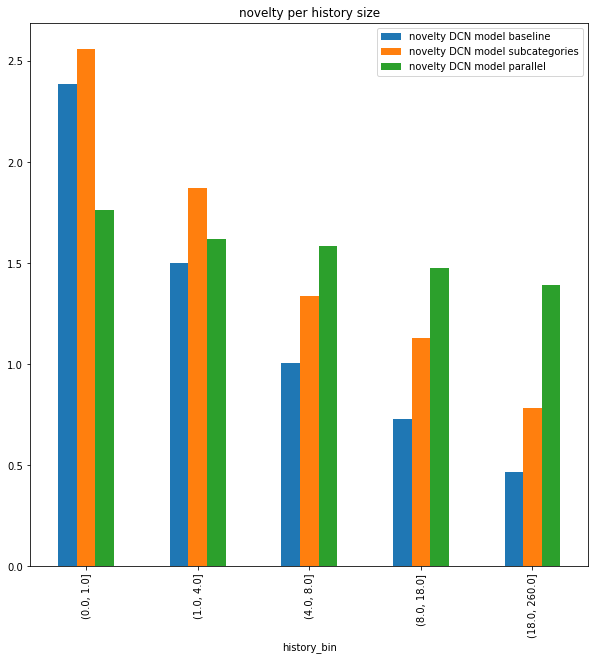

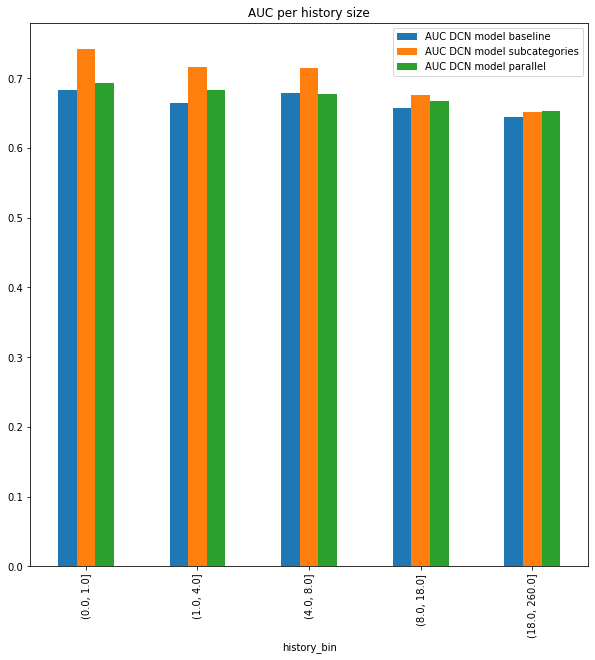

In [ ]:
models = OrderedDict((c, c[5:]) for c in test_df.columns if c.startswith("pred_"))

evaluate(
    sampled_users,
    test_df.rename(columns=models),
    models.values(),
    "click",
    display
)